In [1]:
using SelfConsistentHartreeFock, SecondQuantizedAlgebra
using LinearAlgebra
import SelfConsistentHartreeFock as SCHF
import SecondQuantizedAlgebra as SQA
using Symbolics
import QuantumCumulants as QC
import HarmonicSteadyState as HSS
using Plots

In [2]:
omega0 = 6.5477*2π;
kappa_tot = 0.000324*2π;
kappa_ext = 0.000275*2π; 
K_exp = 0.000523*2π;
Delta_exp = 0.2*2π # Ghz (200 Mhz)

fixed_F = 175/1e3*2*π

δ_range = range(-0.07 * Delta_exp , 0.005 * Delta_exp, 500) |> collect
ωd_range = omega0 .+ δ_range |> collect;

## Meanfield

In [3]:
h₁ = QC.FockSpace(:cavity1)
h₂ = QC.FockSpace(:cavity2)
h₃ = QC.FockSpace(:cavity3)
h = QC.tensor(h₁, h₂, h₃)

QC.@qnumbers b1::Destroy(h, 1) b2::Destroy(h, 2) b3::Destroy(h, 3)
@variables F::Real δ::Real Δ::Real K::Real κ::Real

H_0(a, Δ) = - Δ * a' * a + K * (a'^2 * a^2) 
H_int = 4*K*(b1'*b1 + b2'*b2)*b3'*b3 + 4*K*b1'*b1*b2'*b2 + 2*K*(b1*b2*b3'*b3' + b1'*b2'*b3*b3)
drive1 = F * (b1' + b1)/2
drive2 = F * (b2' + b2)/2
H = H_0(b1, δ - Δ/2) + H_0(b2, δ + Δ/2) + H_0(b3, δ) + drive1 + drive2 + H_int 

ops = [b1, b2, b3]
eqs_RWA = QC.meanfield(ops, H, ops; rates=[κ,κ,κ], order=1)

∂ₜ(⟨b1⟩) = (-0.5F*im) + (im*(-(1//2)*Δ + δ))*⟨b1⟩ - 0.5⟨b1⟩*κ + (-4K*im)*⟨b2⟩*⟨b1⟩*⟨b2′⟩ + (-2K*im)*(⟨b1⟩^2)*⟨b1′⟩ + (-4K*im)*⟨b1⟩*⟨b3′⟩*⟨b3⟩ + (-2K*im)*⟨b2′⟩*(⟨b3⟩^2)
∂ₜ(⟨b2⟩) = (-0.5F*im) + (im*((1//2)*Δ + δ))*⟨b2⟩ - 0.5⟨b2⟩*κ + (-2K*im)*(⟨b2⟩^2)*⟨b2′⟩ + (-4K*im)*⟨b2⟩*⟨b1⟩*⟨b1′⟩ + (-4K*im)*⟨b2⟩*⟨b3′⟩*⟨b3⟩ + (-2K*im)*⟨b1′⟩*(⟨b3⟩^2)
∂ₜ(⟨b3⟩) = (im*δ)*⟨b3⟩ - 0.5⟨b3⟩*κ + (-4K*im)*⟨b2⟩*⟨b1⟩*⟨b3′⟩ + (-4K*im)*⟨b2⟩*⟨b2′⟩*⟨b3⟩ + (-4K*im)*⟨b1⟩*⟨b1′⟩*⟨b3⟩ + (-2K*im)*⟨b3′⟩*(⟨b3⟩^2)


In [4]:
fixed = (K => -K_exp, κ => kappa_tot, Δ => Delta_exp, F => fixed_F) 
varied = (δ => δ_range)
problem = HSS.HomotopyContinuationProblem(QC.complete(eqs_RWA), [K, κ, F, δ, Δ], varied, fixed)

result = HSS.get_steady_states(problem, HSS.WarmUp())

Tracking 729 paths...   0%|▏                            |  ETA: 0:45:28



Tracking 729 paths... 100%|█████████████████████████████| Time: 0:00:08
                   # paths tracked: 729
   # non-singular solutions (real): 45 (0)
       # singular endpoints (real): 0 (0)
          # total solutions (real): 45 (0)
Solving for 500 parameters...  56%|███████████▊         |  ETA: 0:00:00

Solving for 500 parameters...  86%|██████████████████   |  ETA: 0:00:00

Solving for 500 parameters... 100%|█████████████████████| Time: 0:00:01
   # parameters solved: 500
       # paths tracked: 22500


A steady state result for 500 parameter points

Solution branches:   45
   of which real:    7
   of which stable:  4

Classes: stable, physical, Hopf


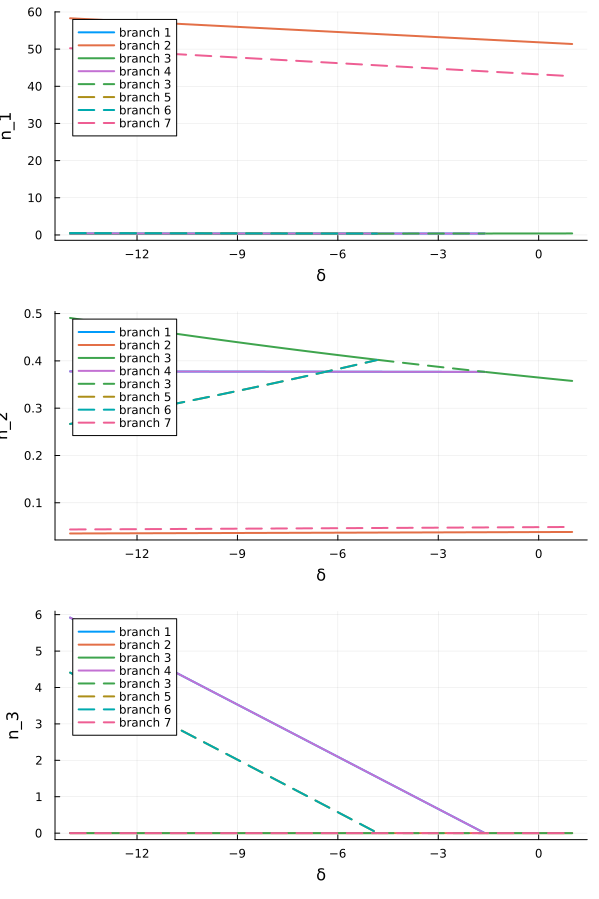

In [5]:
plts = map(1:3) do j
    plt = plot(; xlabel="δ", ylabel="n_$(j)")

    branches = HSS.get_branches( result, "(b$(j)ᵣ^2+b$(j)ᵢ^2)/2"; realify=true, class=["stable"], not_class=[])
    branches_unstable = HSS.get_branches( result, "(b$(j)ᵣ^2+b$(j)ᵢ^2)/2"; realify=true, class=["physical"], not_class=["stable"])
    for i in eachindex(branches)
        all(isnan, branches[i]) && continue
        plot!(plt, δ_range* 1e3 / 2π, branches[i], linewidth=2, label="branch $i", color=i)
    end
    for i in eachindex(branches_unstable)
        all(isnan, branches_unstable[i]) && continue
        plot!(plt, δ_range* 1e3 / 2π, branches_unstable[i], linewidth=2, label="branch $i", color=i, linestyle=:dash)
    end
    plt
end
plot(plts..., layout=(3,1), size=(600,900))

In [6]:
meanfield = map(1:3) do j
    branches_real = HSS.get_branches(result, "b$(j)ᵣ"; class=["stable"], not_class=[])
    branches_imag = HSS.get_branches(result, "b$(j)ᵢ"; class=["stable"], not_class=[])
    tmp1 = @. branches_real[4] + im * branches_imag[4]
    tmp2 = @. branches_real[3] + im * branches_imag[3]
    for i in eachindex(tmp1)
        tmp1[i] = isnan(tmp1[i]) ? tmp2[i] : tmp1[i]
    end
    tmp1
end
meanfield_sol = map(eachindex(meanfield[1])) do i
   getindex.(meanfield, i)
end;

## Hartree-Fock

### System
$$
H=-\Delta d^\dagger a + k d^\dagger d^\dagger a a + F (d^\dagger + a)
$$

In [7]:
h₁ = FockSpace(:cavity1)
h₂ = FockSpace(:cavity2)
h₃ = FockSpace(:cavity3)
h = tensor(h₁, h₂, h₃)

@qnumbers a1::Destroy(h, 1) a2::Destroy(h, 2) a3::Destroy(h, 3)
@variables F::Real δ::Real Δ::Real K::Real κ::Real

H_0(a, Δ) = - Δ * a' * a + K * (a'^2 * a^2) 
H_int = 4*K*(a1'*a1 + a2'*a2)*a3'*a3 + 4*K*a1'*a1*a2'*a2 + 2*K*(a1*a2*a3'*a3' + a1'*a2'*a3*a3)
drive1 = F * (a1' + a1)/2
drive2 = F * (a2' + a2)/2
H = H_0(a1, δ - Δ/2) + H_0(a2, δ + Δ/2) + H_0(a3, δ) + drive1 + drive2 + H_int 

((1//2)*Δ - δ*(a1′*a1)+K*(a1′*a1′*a1*a1)+-(1//2)*Δ - δ*(a2′*a2)+K*(a2′*a2′*a2*a2)+-δ*(a3′*a3)+K*(a3′*a3′*a3*a3)+0.5F*(a1′)+0.5F*(a1)+0.5F*(a2′)+0.5F*(a2)+4K*(a1′*a1*a3′*a3)+4K*(a2′*a2*a3′*a3)+4K*(a1′*a1*a2′*a2)+2K*(a1*a2*a3′*a3′)+2K*(a1′*a2′*a3*a3))

In [8]:
sys = HartreeFockSystem(H, [a1,a2,a3], [κ,κ,κ])
system_dict = collect_dict(sys.H)

Dict{Any, Any} with 28 entries:
  a3        => -⟨a3′⟩*δ + 4K*⟨a1⟩*⟨a1′*a3′⟩ + 4K*⟨a2⟩*⟨a2′*a3′⟩ + 4K*⟨a2′*a2⟩*⟨…
  (a1*a3)   => 4K*⟨a1′*a3′⟩ + 4K*⟨a1′⟩*⟨a3′⟩
  (a1′*a1′) => K*⟨a1*a1⟩ + K*(⟨a1⟩^2)
  a1        => 0.5F + ⟨a1′⟩*((1//2)*Δ - δ) + 2K*⟨a1⟩*⟨a1′*a1′⟩ + 4K*⟨a2⟩*⟨a1′*a…
  a3′       => -⟨a3⟩*δ + 4K*⟨a1⟩*⟨a2*a3′⟩ + 4K*⟨a1⟩*⟨a1′*a3⟩ + 4K*⟨a2⟩*⟨a2′*a3⟩…
  (a2*a2)   => K*⟨a2′*a2′⟩ + K*(⟨a2′⟩^2)
  (a1′*a1)  => (1//2)*Δ - δ + 4K*⟨a2′*a2⟩ + 4K*⟨a3′*a3⟩ + 4K*⟨a1′*a1⟩ + 4K*⟨a1⟩…
  1.0       => 0.5F*⟨a1⟩ + 0.5F*⟨a2⟩ + 0.5F*⟨a2′⟩ + 0.5F*⟨a1′⟩ + ⟨a1⟩*⟨a1′⟩*((1…
  (a2*a3)   => 4K*⟨a2′*a3′⟩ + 4K*⟨a2′⟩*⟨a3′⟩
  (a1′*a2)  => 4K*⟨a1*a2′⟩ + 4K*⟨a1⟩*⟨a2′⟩
  (a1′*a2′) => 4K*⟨a1*a2⟩ + 2K*⟨a3*a3⟩ + 4K*⟨a1⟩*⟨a2⟩ + 2K*(⟨a3⟩^2)
  a1′       => 0.5F + ⟨a1⟩*((1//2)*Δ - δ) + 4K*⟨a1⟩*⟨a2′*a2⟩ + 4K*⟨a1⟩*⟨a3′*a3⟩…
  (a1′*a3′) => 4K*⟨a1*a3⟩ + 4K*⟨a1⟩*⟨a3⟩
  (a1*a2)   => 4K*⟨a1′*a2′⟩ + 2K*⟨a3′*a3′⟩ + 4K*⟨a2′⟩*⟨a1′⟩ + 2K*(⟨a3′⟩^2)
  (a3′*a3)  => -δ + 4K*⟨a2′*a2⟩ + 4K*⟨a3′*a3⟩ + 4K*⟨a1′*a1⟩ + 4K*⟨a1⟩*⟨a1′⟩ + 4…
  (a2

In [9]:
system_dict[a3'*a3] |> display
system_dict[a3*a3]

-δ + 4K*⟨a2′*a2⟩ + 4K*⟨a3′*a3⟩ + 4K*⟨a1′*a1⟩ + 4K*⟨a1⟩*⟨a1′⟩ + 4K*⟨a2⟩*⟨a2′⟩ + 4K*⟨a3′⟩*⟨a3⟩

2K*⟨a1′*a2′⟩ + K*⟨a3′*a3′⟩ + 2K*⟨a2′⟩*⟨a1′⟩ + K*(⟨a3′⟩^2)

In [10]:
a1'*a2' |> display
a2'*a1'

(a1′*a2′)

(a1′*a2′)

In [11]:
system_dict[a1'*a2'] |> display
system_dict[a2'*a1'] 

4K*⟨a1*a2⟩ + 2K*⟨a3*a3⟩ + 4K*⟨a1⟩*⟨a2⟩ + 2K*(⟨a3⟩^2)

4K*⟨a1*a2⟩ + 2K*⟨a3*a3⟩ + 4K*⟨a1⟩*⟨a2⟩ + 2K*(⟨a3⟩^2)

In [12]:
correlators = sys.correlators

15-element Vector{SecondQuantizedAlgebra.QMul}:
 (a1′*a1)
 (a1*a2′)
 (a1*a3′)
 (a1′*a2)
 (a2′*a2)
 (a2*a3′)
 (a1′*a3)
 (a2′*a3)
 (a3′*a3)
 (a1*a1)
 (a1*a2)
 (a2*a2)
 (a1*a3)
 (a2*a3)
 (a3*a3)

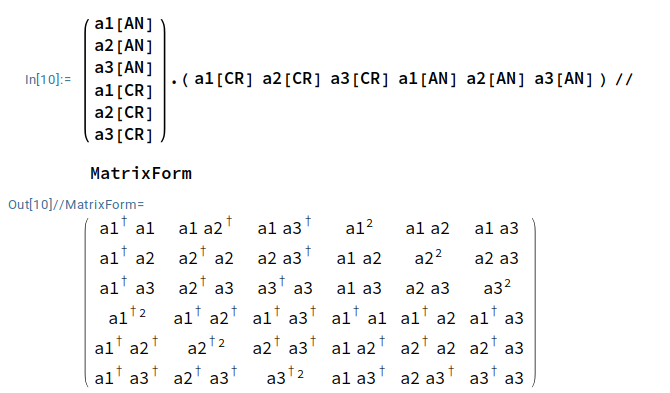

In [13]:
sys.dynamical_matrix.A

3×3 Matrix{Num}:
 (1//2)*Δ - δ + 4K*⟨a2′*a2⟩ + 4K*⟨a3′*a3⟩ + 4K*⟨a1′*a1⟩ + 4K*⟨a1⟩*⟨a1′⟩ + 4K*⟨a2⟩*⟨a2′⟩ + 4K*⟨a3′⟩*⟨a3⟩  …                                     4K*⟨a2′*a3⟩ + 4K*⟨a1*a3′⟩ + 4K*⟨a1⟩*⟨a3′⟩ + 4K*⟨a2′⟩*⟨a3⟩
                                                                            4K*⟨a1′*a2⟩ + 4K*⟨a2⟩*⟨a1′⟩                                        4K*⟨a2*a3′⟩ + 4K*⟨a1′*a3⟩ + 4K*⟨a2⟩*⟨a3′⟩ + 4K*⟨a1′⟩*⟨a3⟩
                                              4K*⟨a2*a3′⟩ + 4K*⟨a1′*a3⟩ + 4K*⟨a2⟩*⟨a3′⟩ + 4K*⟨a1′⟩*⟨a3⟩     -δ + 4K*⟨a2′*a2⟩ + 4K*⟨a3′*a3⟩ + 4K*⟨a1′*a1⟩ + 4K*⟨a1⟩*⟨a1′⟩ + 4K*⟨a2⟩*⟨a2′⟩ + 4K*⟨a3′⟩*⟨a3⟩

In [14]:
sys.dynamical_matrix.B

3×3 Matrix{Num}:
                               2(K*⟨a1*a1⟩ + K*(⟨a1⟩^2))  …                           2(4K*⟨a1*a3⟩ + 4K*⟨a1⟩*⟨a3⟩)
 2(4K*⟨a1*a2⟩ + 2K*⟨a3*a3⟩ + 4K*⟨a1⟩*⟨a2⟩ + 2K*(⟨a3⟩^2))                              2(4K*⟨a2*a3⟩ + 4K*⟨a2⟩*⟨a3⟩)
                            2(4K*⟨a1*a3⟩ + 4K*⟨a1⟩*⟨a3⟩)     2(2K*⟨a1*a2⟩ + K*⟨a3*a3⟩ + 2K*⟨a1⟩*⟨a2⟩ + K*(⟨a3⟩^2))

In [15]:
sys.mean_field_eom

6-element Vector{Num}:
    0.5F + ⟨a1′⟩*((1//2)*Δ - δ) + 2K*⟨a1⟩*⟨a1′*a1′⟩ + 4K*⟨a2⟩*⟨a1′*a2′⟩ + 2K*⟨a2⟩*⟨a3′*a3′⟩ + 4K*⟨a1′*a3′⟩*⟨a3⟩ + 4K*⟨a2′*a2⟩*⟨a1′⟩ + 4K*⟨a2*a3′⟩*⟨a3′⟩ + 4K*⟨a2′⟩*⟨a1′*a2⟩ + 4K*⟨a3′*a3⟩*⟨a1′⟩ + 4K*⟨a1′⟩*⟨a1′*a1⟩ + 4K*⟨a3′⟩*⟨a1′*a3⟩ + 2K*⟨a1⟩*(⟨a1′⟩^2) + 4K*⟨a2⟩*⟨a2′⟩*⟨a1′⟩ + 2K*⟨a2⟩*(⟨a3′⟩^2) + 4K*⟨a1′⟩*⟨a3′⟩*⟨a3⟩
   0.5F + ⟨a2′⟩*(-(1//2)*Δ - δ) + 2K*⟨a2′*a2′⟩*⟨a2⟩ + 4K*⟨a1⟩*⟨a1′*a2′⟩ + 2K*⟨a1⟩*⟨a3′*a3′⟩ + 4K*⟨a2′*a2⟩*⟨a2′⟩ + 4K*⟨a2′⟩*⟨a3′*a3⟩ + 4K*⟨a2′⟩*⟨a1′*a1⟩ + 4K*⟨a2′*a3⟩*⟨a3′⟩ + 4K*⟨a1*a2′⟩*⟨a1′⟩ + 4K*⟨a1*a3′⟩*⟨a3′⟩ + 4K*⟨a2′*a3′⟩*⟨a3⟩ + 4K*⟨a1⟩*⟨a2′⟩*⟨a1′⟩ + 2K*⟨a1⟩*(⟨a3′⟩^2) + 2K*⟨a2⟩*(⟨a2′⟩^2) + 4K*⟨a2′⟩*⟨a3′⟩*⟨a3⟩
 -⟨a3′⟩*δ + 4K*⟨a1⟩*⟨a1′*a3′⟩ + 4K*⟨a2⟩*⟨a2′*a3′⟩ + 4K*⟨a2′*a2⟩*⟨a3′⟩ + 4K*⟨a2*a3′⟩*⟨a2′⟩ + 4K*⟨a2′⟩*⟨a1′*a3⟩ + 4K*⟨a3′*a3⟩*⟨a3′⟩ + 4K*⟨a2′*a3⟩*⟨a1′⟩ + 4K*⟨a1′*a2′⟩*⟨a3⟩ + 4K*⟨a1′⟩*⟨a1*a3′⟩ + 4K*⟨a3′⟩*⟨a1′*a1⟩ + 2K*⟨a3⟩*⟨a3′*a3′⟩ + 4K*⟨a1⟩*⟨a1′⟩*⟨a3′⟩ + 4K*⟨a2⟩*⟨a2′⟩*⟨a3′⟩ + 4K*⟨a2′⟩*⟨a1′⟩*⟨a3⟩ + 2K*(⟨a3′⟩^2)*⟨a3⟩
                 0.5F + ⟨a1⟩*

In [16]:
p = Dict(K => -K_exp, κ => kappa_tot, Δ => Delta_exp, δ => δ_range[1], F => fixed_F)
problem = IterativeProblem(sys, p)

IterativeProblem

In [17]:
problem.unknowns

18-element Vector{SymbolicUtils.BasicSymbolic{SecondQuantizedAlgebra.AvgSym}}:
 ⟨a1⟩
 ⟨a2⟩
 ⟨a3⟩
 ⟨a1′*a1⟩
 ⟨a1*a2′⟩
 ⟨a1*a3′⟩
 ⟨a1′*a2⟩
 ⟨a2′*a2⟩
 ⟨a2*a3′⟩
 ⟨a1′*a3⟩
 ⟨a2′*a3⟩
 ⟨a3′*a3⟩
 ⟨a1*a1⟩
 ⟨a1*a2⟩
 ⟨a2*a2⟩
 ⟨a1*a3⟩
 ⟨a2*a3⟩
 ⟨a3*a3⟩

In [42]:
α0 = zeros(ComplexF64, 18)
α0[1:3] = meanfield_sol[end]
α0

18-element Vector{ComplexF64}:
 -0.9053601123332782 + 0.0015175775570218787im
  0.8457117075495384 + 0.0013241973419104336im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im

In [43]:
fixed_point(problem, α0)

Dict{SymbolicUtils.BasicSymbolic{SecondQuantizedAlgebra.AvgSym}, ComplexF64} with 18 entries:
  ⟨a3⟩     => 4.03344e-18+4.71284e-19im
  ⟨a1′*a3⟩ => 1.54664e-17-4.52446e-18im
  ⟨a3*a3⟩  => -0.129289-0.00312968im
  ⟨a1*a2′⟩ => 0.000836785+6.56856e-5im
  ⟨a2′*a2⟩ => 0.155008+0.0im
  ⟨a2*a3′⟩ => 4.76368e-18+2.29305e-18im
  ⟨a1⟩     => -0.825115-0.00017245im
  ⟨a2′*a3⟩ => 4.76368e-18-2.29305e-18im
  ⟨a1′*a1⟩ => 0.15493+0.0im
  ⟨a1*a2⟩  => -0.318314-0.00770807im
  ⟨a1′*a2⟩ => 0.000836785-6.56856e-5im
  ⟨a2⟩     => 0.944864-0.000172596im
  ⟨a3′*a3⟩ => 0.03147+0.0im
  ⟨a2*a2⟩  => -0.0124182-0.000115229im
  ⟨a2*a3⟩  => -1.42709e-17-2.23803e-17im
  ⟨a1*a3⟩  => -1.05297e-18+1.19871e-19im
  ⟨a1*a1⟩  => 0.00897372+0.000128209im
  ⟨a1*a3′⟩ => 1.54664e-17+4.52446e-18im

In [44]:
dics = map(meanfield_sol) do α
    α0 = zeros(ComplexF64, 18)
    α0[1:3] = α
    fp = fixed_point(problem, α0)
end;
dics[end]

Dict{SymbolicUtils.BasicSymbolic{SecondQuantizedAlgebra.AvgSym}, ComplexF64} with 18 entries:
  ⟨a3⟩     => 4.03344e-18+4.71284e-19im
  ⟨a1′*a3⟩ => 1.54664e-17-4.52446e-18im
  ⟨a3*a3⟩  => -0.129289-0.00312968im
  ⟨a1*a2′⟩ => 0.000836785+6.56856e-5im
  ⟨a2′*a2⟩ => 0.155008+0.0im
  ⟨a2*a3′⟩ => 4.76368e-18+2.29305e-18im
  ⟨a1⟩     => -0.825115-0.00017245im
  ⟨a2′*a3⟩ => 4.76368e-18-2.29305e-18im
  ⟨a1′*a1⟩ => 0.15493+0.0im
  ⟨a1*a2⟩  => -0.318314-0.00770807im
  ⟨a1′*a2⟩ => 0.000836785-6.56856e-5im
  ⟨a2⟩     => 0.944864-0.000172596im
  ⟨a3′*a3⟩ => 0.03147+0.0im
  ⟨a2*a2⟩  => -0.0124182-0.000115229im
  ⟨a2*a3⟩  => -1.42709e-17-2.23803e-17im
  ⟨a1*a3⟩  => -1.05297e-18+1.19871e-19im
  ⟨a1*a1⟩  => 0.00897372+0.000128209im
  ⟨a1*a3′⟩ => 1.54664e-17+4.52446e-18im

In [36]:
a1s = getindex.(dics, SQA.average(a1))
a2s = getindex.(dics, SQA.average(a2))
a3s = getindex.(dics, SQA.average(a3))

500-element Vector{ComplexF64}:
   9.582829551005161e-13 - 3.3801916850240373e-13im
   -9.06030914472884e-12 - 7.47892804389308e-11im
  1.7275230674023546e-12 + 7.753471745322759e-11im
 -2.0760745612010448e-12 - 2.4873371853478976e-10im
 -1.0610956282073497e-11 + 6.225437193195046e-11im
     -2.8705459378975604 - 0.007948335113351912im
  2.7027965070336013e-13 - 1.2225339345747516e-10im
  2.3321577972287867e-14 + 2.0099631474228727e-11im
  -2.672791439483208e-12 + 2.7610590033086803e-10im
  1.3526516641316403e-13 - 8.165734002125753e-13im
                         ⋮
  -5.785720800195178e-19 + 8.452647905255011e-18im
  1.0727525352974074e-20 + 1.397969754271143e-17im
  -2.336065926135882e-18 + 8.176145631428716e-18im
   6.222423647615018e-19 - 2.2157872339491812e-17im
  2.6153657660198523e-18 - 7.308564357239288e-18im
  6.7395740792386416e-18 - 8.648594877819155e-19im
  3.1199030566218503e-19 - 2.4147406340892283e-17im
 -1.4313239186466423e-18 + 8.879967569406374e-18im
  4.03344036910845

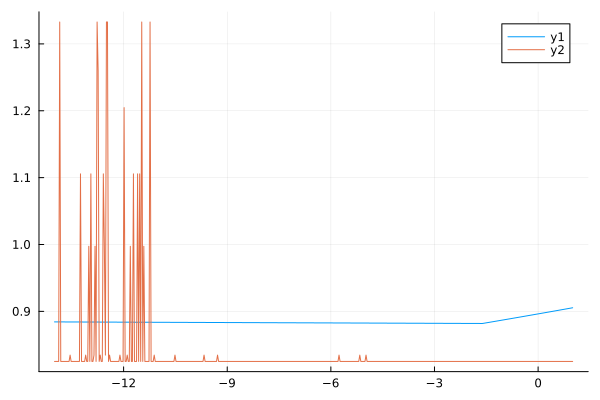

In [45]:
plot( δ_range* 1e3 / 2π, abs.(getindex.(meanfield_sol,1)))
plot!( δ_range* 1e3 / 2π, abs.(a1s))